In [116]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [117]:
index_of_hospital_for_prediction = 8

In [118]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

dfs = []

# loop through all files in the folder and read them and append them to the list
index = 0

for file in glob.glob('../../Data/Processed data/*.xlsx'):
    print(file + " " + str(index))
    df = read_excel(file)
    dfs.append(df)
    index += 1


../../Data/Processed data\250 shojja.xlsx 0
../../Data/Processed data\31 shojja.xlsx 1
../../Data/Processed data\ad-din.xlsx 2
../../Data/Processed data\aichi.xlsx 3
../../Data/Processed data\Al manar.xlsx 4
../../Data/Processed data\Anowar khan.xlsx 5
../../Data/Processed data\azgol ali.xlsx 6


../../Data/Processed data\Delta medical.xlsx 7
../../Data/Processed data\Dhaka central.xlsx 8
../../Data/Processed data\dmd central.xlsx 9
../../Data/Processed data\h&h.xlsx 10
../../Data/Processed data\hfrc.xlsx 11
../../Data/Processed data\ibn sina.xlsx 12
../../Data/Processed data\islami bank.xlsx 13
../../Data/Processed data\lstm_dmc.xlsx 14
../../Data/Processed data\Medical college for women.xlsx 15
../../Data/Processed data\Metropoliton medical.xlsx 16
../../Data/Processed data\police hospital.xlsx 17
../../Data/Processed data\popular medical.xlsx 18
../../Data/Processed data\Sajeda hospital.xlsx 19
../../Data/Processed data\shomorita.xlsx 20
../../Data/Processed data\Square.xlsx 21
../../Data/Processed data\ssmc.xlsx 22
../../Data/Processed data\united hospital.xlsx 23
../../Data/Processed data\universal.xlsx 24
../../Data/Processed data\Uttara adhunik.xlsx 25


In [119]:
coordinates = [(23.78023378522258, 90.36734693327269),
               (23.717878894611427, 90.37687614386095),
               (23.74854258987857, 90.4054805619277),
               (23.881790066203926, 90.40410896582604),
               (23.756052674223117, 90.36321845418024),
               (23.74530536688184, 90.38222402534431),
               (23.70789594683928, 90.42361642349367),
               (23.788602125062823, 90.35348610815265),
               (23.74361497588872, 90.38411443909085),
               (23.743909512744548, 90.38430874415275),
               (23.751892721210428, 90.38546900815183),
               (23.74692774941598, 90.40312845418005),
               (23.752132125860218, 90.41353537340008),
               (23.73972361480249, 90.4206285118513),
               (23.726327283426574, 90.39766652719375),
               (23.858439631417777, 90.40093773883972),
               (23.858439631417777, 90.40089482349694),
               (23.736396173493542, 90.41672412478748),
               (23.739433993904264, 90.38224623884184),
               (23.703267796399004, 90.3887789409448),
               (23.753565317444227, 90.3852717198413),
               (23.752951798763714, 90.38150615233585),
               (23.710654780247634, 90.40201004780278),
               (23.804802336161362, 90.41579431185583),
               (23.77636504355202, 90.39571531185526),
               (23.87475779737836, 90.39663462350299),
               ]

In [120]:
len(dfs)

26

In [121]:
# size of coordinates
len(coordinates)

26

In [122]:
def preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].values.astype(float)
    #sort by date
    df = df.sort_values(by='Date')
    # for rows where df['Affected'] is null or non-numeric, replace with 0
    df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
    df.reset_index(drop=True, inplace=True)
    return df

In [123]:
i=1

for df in dfs:
    print(str(i))
    df = preprocess(df)
    print("done ")
    i+=1

1
done 
2
done 
3
done 
4
done 
5
done 
6
done 
7
done 
8
done 
9
done 
10
done 
11
done 
12
done 
13
done 
14
done 
15
done 
16
done 
17
done 
18
done 
19
done 
20
done 
21
done 
22
done 
23
done 
24
done 
25
done 
26
done 


In [124]:
# find distance between two coordinates
def distance(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d

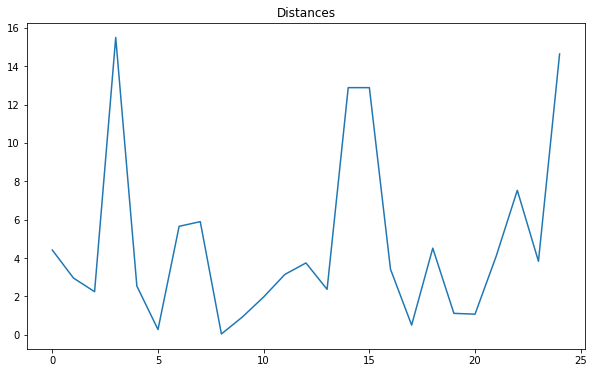

In [125]:
distances_from_other_hospitals = []

#find distances from each hospital to the hospital at index 13 except its own and append to the list
for i in range(len(coordinates)):
    if i != index_of_hospital_for_prediction:
        distances_from_other_hospitals.append(distance(coordinates[index_of_hospital_for_prediction][0], coordinates[index_of_hospital_for_prediction][1], coordinates[i][0], coordinates[i][1]))

#plot the distances
plt.figure(figsize=(10,6))
plt.plot(distances_from_other_hospitals)
plt.title('Distances')
plt.show()


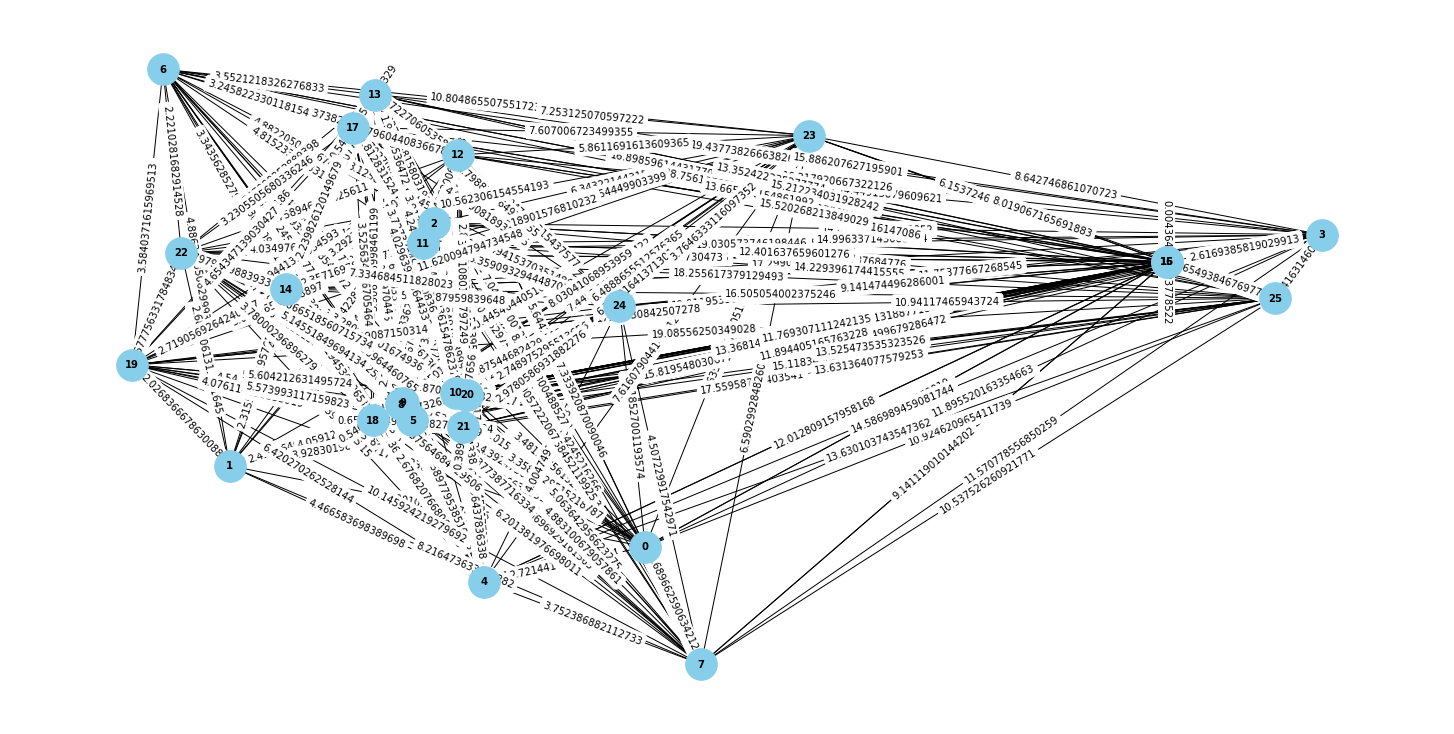

In [126]:
# Make a graph of nodes and edges with weights as distances
import networkx as nx
G = nx.Graph()
for i in range(len(coordinates)):
    G.add_node(i, pos=(coordinates[i][0], coordinates[i][1]))
for i in range(len(coordinates)):
    for j in range(i+1, len(coordinates)):
        G.add_edge(i, j, weight=distance(coordinates[i][0], coordinates[i][1], coordinates[j][0], coordinates[j][1]))

pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(20,10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [127]:
#check if all df in dfs have the same length
for df in dfs:
    print(len(df))


551
551
683
156
156
698
698
698
454
698
698
698
698
698
698
538
156
699
698
156
698
698
699
698
698
698


In [128]:
#check the df size of the hospital at index 13
len(dfs[index_of_hospital_for_prediction])

454

In [129]:
# what is the highest size of the df
max_size = max([len(df) for df in dfs])
max_size

699

In [130]:
# make all the dfs equal size: equal to the size of the hospital with index for prediction
# get the hospital with highest df
# get the index of the hospital with highest df


# for each 'Date' value in the hospital with index for prediction, if other hospitals do not have that 'Date' value, add that 'Date' value to the other hospitals with 'Affected' value as 0
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[index_of_hospital_for_prediction]['Date']:
            if date not in dfs[i]['Date'].values:
                dfs[i] = pd.concat([dfs[i], pd.DataFrame({'Date': [date], 'Affected': [0]})], ignore_index=True)
        
# If any df has any date value that is not in the hospital with index for prediction, remove that row from the df
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for date in dfs[i]['Date']:
            if date not in dfs[index_of_hospital_for_prediction]['Date'].values:
                dfs[i] = dfs[i][dfs[i]['Date'] != date]



In [131]:
#now check the size of the dfs again
for df in dfs:
    print(len(df))

454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454
454


In [132]:
# now make a new dataframe where first column is the Affected column of our prediction hospital

data = dfs[index_of_hospital_for_prediction][['Affected']]


In [133]:
data.head()

,Affected
0,0.0
1,0.0
2,1.0
3,0.0
4,2.0


In [134]:
# normalize distance values by their weighted average: value/sum

distances_from_other_hospitals = np.array(distances_from_other_hospitals)
distances_from_other_hospitals = distances_from_other_hospitals/np.sum(distances_from_other_hospitals)
distances_from_other_hospitals 

array([0.03737836, 0.02501853, 0.01898692, 0.13121518, 0.02147819,
       0.00227731, 0.04785169, 0.0499002 , 0.00032391, 0.00787973,
       0.01667893, 0.02658986, 0.03167832, 0.02003179, 0.1090647 ,
       0.1090598 , 0.02891162, 0.00425256, 0.03819563, 0.00942034,
       0.00907264, 0.03465095, 0.0637416 , 0.03241125, 0.12393   ])

In [135]:
# now subtract each value from 1
distances_from_other_hospitals = 1 - distances_from_other_hospitals
distances_from_other_hospitals

array([0.96262164, 0.97498147, 0.98101308, 0.86878482, 0.97852181,
       0.99772269, 0.95214831, 0.9500998 , 0.99967609, 0.99212027,
       0.98332107, 0.97341014, 0.96832168, 0.97996821, 0.8909353 ,
       0.8909402 , 0.97108838, 0.99574744, 0.96180437, 0.99057966,
       0.99092736, 0.96534905, 0.9362584 , 0.96758875, 0.87607   ])

In [136]:
# agian get the weighted average
distances_from_other_hospitals = distances_from_other_hospitals/np.sum(distances_from_other_hospitals)
distances_from_other_hospitals

array([0.04010924, 0.04062423, 0.04087554, 0.03619937, 0.04077174,
       0.04157178, 0.03967285, 0.03958749, 0.04165317, 0.04133834,
       0.04097171, 0.04055876, 0.04034674, 0.04083201, 0.0371223 ,
       0.03712251, 0.04046202, 0.04148948, 0.04007518, 0.04127415,
       0.04128864, 0.04022288, 0.03901077, 0.0403162 , 0.03650292])

In [137]:
# now add columns for each hospital in the data dataframe
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        data['Hospital_'+str(i)] = dfs[i]['Affected']

data.head()

,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_9,...,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25
0,0.0,NaN,NaN,NaN,6.0,13.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,13.0,8.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,13.0,18.0,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,NaN,NaN,14.0,14.0,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,NaN,NaN,NaN,17.0,15.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
# if any cell is null or contains non-numeric value, replace with 0
data = data.fillna(0)
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
data.head()



,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_9,...,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25
0,0.0,0,0,0,6.0,13.0,0,0,0,0,...,1.0,0,0,7.0,0,0,0,0,0,0
1,0.0,0,0,0,13.0,8.0,0,0,0,0,...,0.0,0,0,4.0,0,0,0,0,0,0
2,1.0,0,0,0,13.0,18.0,0,0,0,0,...,2.0,0,0,7.0,0,0,0,0,0,0
3,0.0,0,0,0,14.0,14.0,0,0,0,0,...,2.0,0,0,9.0,0,0,0,0,0,0
4,2.0,0,0,0,17.0,15.0,0,0,0,0,...,0.0,0,0,0.0,0,0,0,0,0,0


In [139]:
# nultiplying each column with the corresponding distance value
j = 0
for i in range(len(dfs)):
    if i != index_of_hospital_for_prediction:
        for k in range(len(data)):
            data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
        j+=1

data.head()

C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Hospital_'+str(i)][k] = float(data['Hospital_'+str(i)][k]) * distances_from_other_hospitals[j]
C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/257819446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_9,...,Hospital_16,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25
0,0.0,0.0,0.0,0.0,0.217196,0.530033,0.0,0.0,0.0,0.0,...,0.037123,0.0,0.0,0.280526,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.470592,0.326174,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.160301,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.470592,0.733891,0.0,0.0,0.0,0.0,...,0.074245,0.0,0.0,0.280526,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.506791,0.570804,0.0,0.0,0.0,0.0,...,0.074245,0.0,0.0,0.360677,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.615389,0.611576,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
# now sum all the columns from  hospital 0 to last to get the final value
data['From other hospitals'] = data.iloc[:, 1:].sum(axis=1)
data.head()

,Affected,Hospital_0,Hospital_1,Hospital_2,Hospital_3,Hospital_4,Hospital_5,Hospital_6,Hospital_7,Hospital_9,...,Hospital_17,Hospital_18,Hospital_19,Hospital_20,Hospital_21,Hospital_22,Hospital_23,Hospital_24,Hospital_25,From other hospitals
0,0.0,0.0,0.0,0.0,0.217196,0.530033,0.0,0.0,0.0,0.0,...,0.0,0.0,0.280526,0.0,0.0,0.0,0.0,0.0,0.0,1.064878
1,0.0,0.0,0.0,0.0,0.470592,0.326174,0.0,0.0,0.0,0.0,...,0.0,0.0,0.160301,0.0,0.0,0.0,0.0,0.0,0.0,0.957066
2,1.0,0.0,0.0,0.0,0.470592,0.733891,0.0,0.0,0.0,0.0,...,0.0,0.0,0.280526,0.0,0.0,0.0,0.0,0.0,0.0,1.559254
3,0.0,0.0,0.0,0.0,0.506791,0.570804,0.0,0.0,0.0,0.0,...,0.0,0.0,0.360677,0.0,0.0,0.0,0.0,0.0,0.0,1.512517
4,2.0,0.0,0.0,0.0,0.615389,0.611576,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.226965


In [141]:
# drop all the column except 'Affected' and 'From other hospitals'
data = data[['Affected', 'From other hospitals']]
data.head()

,Affected,From other hospitals
0,0.0,1.064878
1,0.0,0.957066
2,1.0,1.559254
3,0.0,1.512517
4,2.0,1.226965


In [142]:
# make a new dataframe where each row of 'data' dataframe makes up two rows of the new dataframe, first row for 'Affected' and second row for 'From other hospitals'. so the new dataframe hase only one column
new_data = pd.DataFrame(columns=['Value'])
for i in range(len(data)):
    new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['Affected'][i]]})], ignore_index=True)
    new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['From other hospitals'][i]]})], ignore_index=True)

new_data.head()


C:\Users\aniki\AppData\Local\Temp/ipykernel_15748/1814953727.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_data = pd.concat([new_data, pd.DataFrame({'Value': [data['Affected'][i]]})], ignore_index=True)


,Value
0,0.000000
1,1.064878
2,0.000000
3,0.957066
4,1.000000


In [143]:
new_data.shape

(908, 1)

In [144]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
input_size = 14
prediction_window = 3
window_size = input_size + prediction_window
hidden_size = 64
num_layers = 1


print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  17  input_size:  14  num_layers:  1


In [145]:
def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples

samples = create_time_series_samples(new_data, window_size)

In [146]:
samples[0]

,Value
0,0.000000
1,1.064878
2,0.000000
3,0.957066
4,1.000000
5,1.559254
6,0.000000
7,1.512517
8,2.000000
9,1.226965


In [147]:
len(samples)

892

In [148]:
new_df = pd.DataFrame([sample['Value'].values for sample in samples])
new_df = new_df.transpose()
new_df.columns = [f'Value_{i}' for i in range(len(samples))]
new_df = new_df.transpose()
new_df.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Value_0,0.000000,1.064878,0.000000,0.957066,1.000000,1.559254,0.000000,1.512517,2.000000,1.226965,0.000000,0.080150,0.000000,1.462057,2.000000,1.335230,4.000000
Value_1,1.064878,0.000000,0.957066,1.000000,1.559254,0.000000,1.512517,2.000000,1.226965,0.000000,0.080150,0.000000,1.462057,2.000000,1.335230,4.000000,1.266707
Value_2,0.000000,0.957066,1.000000,1.559254,0.000000,1.512517,2.000000,1.226965,0.000000,0.080150,0.000000,1.462057,2.000000,1.335230,4.000000,1.266707,4.000000
Value_3,0.957066,1.000000,1.559254,0.000000,1.512517,2.000000,1.226965,0.000000,0.080150,0.000000,1.462057,2.000000,1.335230,4.000000,1.266707,4.000000,1.129341
Value_4,1.000000,1.559254,0.000000,1.512517,2.000000,1.226965,0.000000,0.080150,0.000000,1.462057,2.000000,1.335230,4.000000,1.266707,4.000000,1.129341,2.000000


In [149]:
#delte each 2nd row
new_df = new_df.iloc[::2]

In [150]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Value_0,0.0,1.064878,0.0,0.957066,1.0,1.559254,0.0,1.512517,2.0,1.226965,0.0,0.080150,0.0,1.462057,2.0,1.335230,4.0
Value_2,0.0,0.957066,1.0,1.559254,0.0,1.512517,2.0,1.226965,0.0,0.080150,0.0,1.462057,2.0,1.335230,4.0,1.266707,4.0
Value_4,1.0,1.559254,0.0,1.512517,2.0,1.226965,0.0,0.080150,0.0,1.462057,2.0,1.335230,4.0,1.266707,4.0,1.129341,2.0
Value_6,0.0,1.512517,2.0,1.226965,0.0,0.080150,0.0,1.462057,2.0,1.335230,4.0,1.266707,4.0,1.129341,2.0,0.779779,5.0
Value_8,2.0,1.226965,0.0,0.080150,0.0,1.462057,2.0,1.335230,4.0,1.266707,4.0,1.129341,2.0,0.779779,5.0,0.699415,1.0


In [151]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(new_df, 0.8, True)

In [152]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [153]:
print("X_train.shape: ", X_train.shape, " y_train.shape: ", y_train.shape, " X_test.shape: ", X_test.shape, " y_test.shape: ", y_test.shape)

X_train.shape:  (356, 14)  y_train.shape:  (356, 3)  X_test.shape:  (90, 14)  y_test.shape:  (90, 3)


In [154]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [155]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, prediction_window)  

    def forward(self, x):
        h_t, _ = self.lstm(x)
        output = self.fc(h_t[:, -1, :]) 
        return output

In [156]:
model = LSTMModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [157]:
train_losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses[epoch] = loss.item()

Epoch [1/500], Loss: 17.3599
Epoch [2/500], Loss: 58.2178
Epoch [3/500], Loss: 21.0227
Epoch [4/500], Loss: 0.2543
Epoch [5/500], Loss: 9.3707
Epoch [6/500], Loss: 1.7014
Epoch [7/500], Loss: 14.9275
Epoch [8/500], Loss: 3.2162
Epoch [9/500], Loss: 7.6669
Epoch [10/500], Loss: 25.1943


Epoch [11/500], Loss: 10.5896
Epoch [12/500], Loss: 0.6556
Epoch [13/500], Loss: 17.6017
Epoch [14/500], Loss: 3.7441
Epoch [15/500], Loss: 12.9805
Epoch [16/500], Loss: 19.4138
Epoch [17/500], Loss: 28.8708
Epoch [18/500], Loss: 23.8032
Epoch [19/500], Loss: 17.0843
Epoch [20/500], Loss: 6.9706
Epoch [21/500], Loss: 3.3476
Epoch [22/500], Loss: 0.7237
Epoch [23/500], Loss: 2.3001
Epoch [24/500], Loss: 0.9738
Epoch [25/500], Loss: 1.1018
Epoch [26/500], Loss: 13.1526
Epoch [27/500], Loss: 12.0017
Epoch [28/500], Loss: 5.4943
Epoch [29/500], Loss: 12.7854
Epoch [30/500], Loss: 29.9283
Epoch [31/500], Loss: 32.8424
Epoch [32/500], Loss: 0.3099
Epoch [33/500], Loss: 20.1958
Epoch [34/500], Loss: 11.5542
Epoch [35/500], Loss: 0.6991
Epoch [36/500], Loss: 2.3183
Epoch [37/500], Loss: 0.4529
Epoch [38/500], Loss: 4.6337
Epoch [39/500], Loss: 15.0281
Epoch [40/500], Loss: 6.0027
Epoch [41/500], Loss: 6.5653
Epoch [42/500], Loss: 4.2056
Epoch [43/500], Loss: 12.7198
Epoch [44/500], Loss: 8.821

In [158]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_outputs.squeeze(), y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

predictions = test_outputs.numpy()

Test Loss: 11.5545


In [159]:
#get the first column of the test set
y_test_1 = y_test[:, 0]
y_test_2 = y_test[:, 1]
# y_test_3 = y_test[:, 2]

# #get the first column of the predictions
predictions_1 = predictions[:, 0]
predictions_2 = predictions[:, 1]
# predictions_3 = predictions[:, 2]

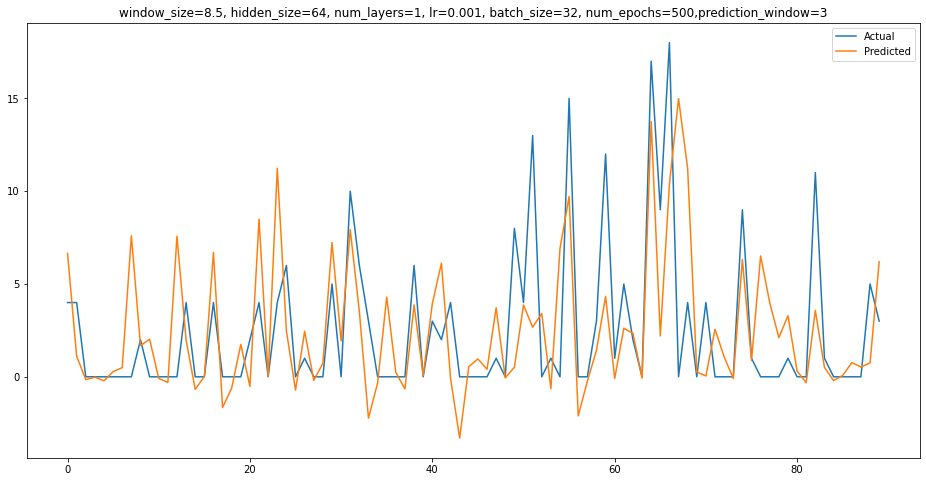

In [160]:
plt.figure(figsize=(16,8))
plt.title(f'window_size={window_size/2}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predictions_1, label='Predicted')
plt.legend()
plt.show()

In [161]:
# test loss on MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(y_test_1, predictions_1))
print("Mean Squared Error: ", mean_squared_error(y_test_1, predictions_1))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test_1, predictions_1)))

Mean Absolute Error:  2.5271219479540985
Mean Squared Error:  14.139597524506378
Root Mean Squared Error:  3.7602656188767276


In [162]:
# print the error upto 2 decimal places
print("Mean Absolute Error: ", round(mean_absolute_error(y_test_1, predictions_1), 2))
print("Mean Squared Error: ", round(mean_squared_error(y_test_1, predictions_1), 2))
print("Root Mean Squared Error: ", round(np.sqrt(mean_squared_error(y_test_1, predictions_1)), 2))

Mean Absolute Error:  2.53
Mean Squared Error:  14.14
Root Mean Squared Error:  3.76
